In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Step 1: Load the dataset
file_path = '/content/attendance_dataset_500k.csv'  # Replace with your dataset path
attendance_data = pd.read_csv(file_path)

In [ ]:
# Step 2: Handle missing values in time columns
attendance_data['Student Sign-in to Lecture'] = attendance_data['Student Sign-in to Lecture'].fillna('00:00')
attendance_data['Student Sign-out from Lecture'] = attendance_data['Student Sign-out from Lecture'].fillna('00:00')

In [ ]:
# Convert time columns to minutes since midnight
def time_to_minutes(time_str):
    if time_str == '00:00':
        return 0
    time = pd.to_datetime(time_str, format='%H:%M')
    return time.hour * 60 + time.minute

attendance_data['Sign-in Minutes'] = attendance_data['Student Sign-in to Lecture'].apply(time_to_minutes)
attendance_data['Sign-out Minutes'] = attendance_data['Student Sign-out from Lecture'].apply(time_to_minutes)
attendance_data['Lecture Start Minutes'] = attendance_data['Time Lecture Started'].apply(time_to_minutes)
attendance_data['Lecture End Minutes'] = attendance_data['Time Lecture Ended'].apply(time_to_minutes)

In [ ]:
# Encode the 'Status' column
label_encoder = LabelEncoder()
attendance_data['Status Encoded'] = label_encoder.fit_transform(attendance_data['Status'])

# Feature engineering
attendance_data['Sign-in Delay'] = attendance_data['Sign-in Minutes'] - attendance_data['Lecture Start Minutes']
attendance_data['Attended Minutes'] = attendance_data['Sign-out Minutes'] - attendance_data['Sign-in Minutes']

# Drop unnecessary columns
columns_to_drop = [
    'Student ID', 'Date', 'Day', 'CourseCode', 'CourseName',
    'Time Lecture Started', 'Time Lecture Ended',
    'Student Sign-in to Lecture', 'Student Sign-out from Lecture', 'Status'
]
processed_data = attendance_data.drop(columns=columns_to_drop)
# Define features (X) and target (y)
X = processed_data.drop(['Status Encoded'], axis=1)
y = processed_data['Status Encoded']

In [ ]:
# Step 3: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
# Build the ANN model
ann_model = Sequential()
ann_model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
ann_model.add(Dropout(0.3))  # Regularization
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dropout(0.3))
ann_model.add(Dense(1, activation='sigmoid'))  # Binary classification


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the ANN model
ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the ANN model
print("\nTraining ANN model...")
ann_history = ann_model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128)


Training ANN model...
Epoch 1/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6208 - loss: -55.7988 - val_accuracy: 0.6668 - val_loss: -1060.9492
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6675 - loss: -2331.0615 - val_accuracy: 0.6668 - val_loss: -8607.9785
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6652 - loss: -12387.3027 - val_accuracy: 0.6668 - val_loss: -26937.4004
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6651 - loss: -33904.5469 - val_accuracy: 0.6668 - val_loss: -58455.4609
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6651 - loss: -69473.0547 - val_accuracy: 0.6668 - val_loss: -104884.0703
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6686 - loss: -119206.9062 - val_accuracy: 0.6668 - val_loss: -167362.5625
Epoch 7/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6648 - loss: -186260.4219 - val_accuracy: 0.6668 - val_loss: -246909.0781
Epoch 8/10
5

In [ ]:
# Evaluate the ANN model
ann_loss, ann_accuracy = ann_model.evaluate(X_test, y_test)
print(f"\nANN Model Accuracy on Test Set: {ann_accuracy * 100:.2f}%")

630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6652 - loss: -597931.5625

ANN Model Accuracy on Test Set: 66.54%


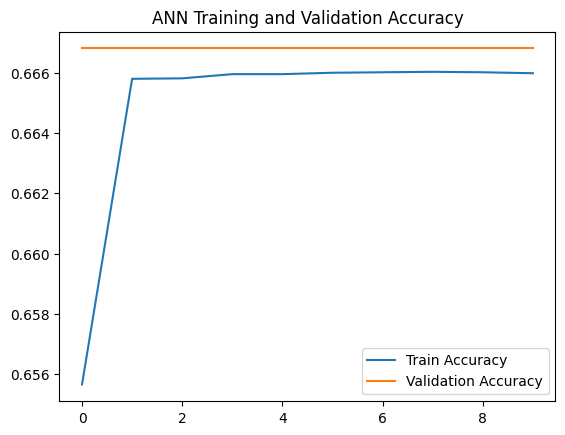

In [ ]:
# Plot training/validation accuracy
import matplotlib.pyplot as plt

plt.plot(ann_history.history['accuracy'], label='Train Accuracy')
plt.plot(ann_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('ANN Training and Validation Accuracy')
plt.show()

In [ ]:
# ---------------------------------------
# Decision Tree Implementation
# ---------------------------------------

In [ ]:
# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

In [ ]:
# Set hyperparameter grid for tuning
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Perform GridSearchCV
print("\nTuning Decision Tree model...")
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)


Tuning Decision Tree model...


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [ ]:
# Get the best Decision Tree model
best_dt_model = grid_search.best_estimator_
print("\nBest Parameters for Decision Tree:", grid_search.best_params_)


Best Parameters for Decision Tree: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
# Evaluate the Decision Tree model
y_pred_dt = best_dt_model.predict(X_test)
print(f"\nDecision Tree Model Accuracy on Test Set: {accuracy_score(y_test, y_pred_dt) * 100:.2f}%")
print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))


Decision Tree Model Accuracy on Test Set: 100.00%

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6722
           1       1.00      1.00      1.00      6691
           2       1.00      1.00      1.00      6744

    accuracy                           1.00     20157
   macro avg       1.00      1.00      1.00     20157
weighted avg       1.00      1.00      1.00     20157



In [ ]:
# Updated ANN with more layers and regularization
from tensorflow.keras.regularizers import l2

# Build a deeper ANN model
ann_model = Sequential()
ann_model.add(Dense(128, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l2(0.01)))
ann_model.add(Dropout(0.4))  # Increase dropout
ann_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
ann_model.add(Dropout(0.4))
ann_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
ann_model.add(Dropout(0.4))
ann_model.add(Dense(1, activation='sigmoid'))

# Compile the model
ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with more epochs and smaller batch size
ann_history = ann_model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=64)

# Evaluate the model
ann_loss, ann_accuracy = ann_model.evaluate(X_test, y_test)
print(f"\nImproved ANN Model Accuracy: {ann_accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.6459 - loss: -88976.3906 - val_accuracy: 0.6668 - val_loss: -2242707.5000
Epoch 2/20
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6643 - loss: -6134728.5000 - val_accuracy: 0.6668 - val_loss: -28543228.0000
Epoch 3/20
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6664 - loss: -44568400.0000 - val_accuracy: 0.6668 - val_loss: -113606424.0000
Epoch 4/20
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6665 - loss: -151011552.0000 - val_accuracy: 0.6668 - val_loss: -290424512.0000
Epoch 5/20
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6630 - loss: -362107200.0000 - val_accuracy: 0.6668 - val_loss: -591562816.0000
Epoch 6/20
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6669 - loss: -694867776.0000 - val_accuracy: 0.6668 - val_loss: -1051889920.0000
Epoch 7/20
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6650 - loss: -1203309696.0000 - val_accuracy: 0.6668

In [ ]:
# Limit depth and use pruning
dt_model = DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate the pruned Decision Tree
y_pred_dt = dt_model.predict(X_test)
print(f"\nPruned Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt) * 100:.2f}%")
print("\nPruned Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))



Pruned Decision Tree Accuracy: 98.66%

Pruned Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6722
           1       1.00      0.96      0.98      6691
           2       0.96      1.00      0.98      6744

    accuracy                           0.99     20157
   macro avg       0.99      0.99      0.99     20157
weighted avg       0.99      0.99      0.99     20157



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest with limited estimators
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
print(f"\nRandom Forest Accuracy: {accuracy_score(y_test, y_pred_rf) * 100:.2f}%")
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))



Random Forest Accuracy: 99.41%

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6722
           1       1.00      0.98      0.99      6691
           2       0.98      1.00      0.99      6744

    accuracy                           0.99     20157
   macro avg       0.99      0.99      0.99     20157
weighted avg       0.99      0.99      0.99     20157



In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled dataset shape: {X_resampled.shape}")


Resampled dataset shape: (80949, 7)


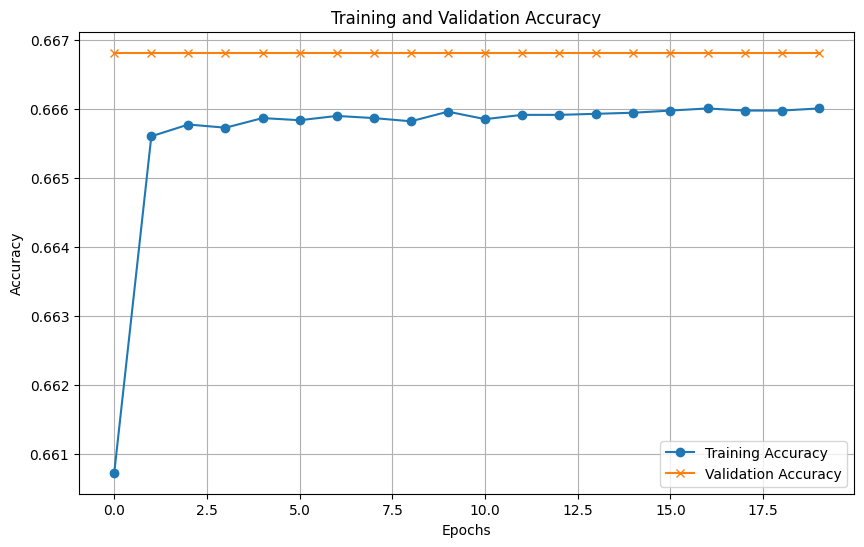

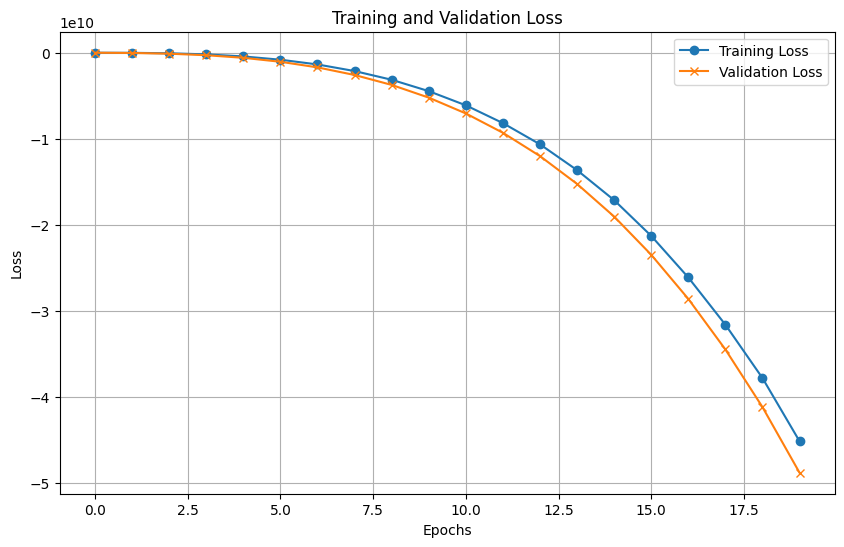

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(ann_history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(ann_history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(ann_history.history['loss'], label='Training Loss', marker='o')
plt.plot(ann_history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


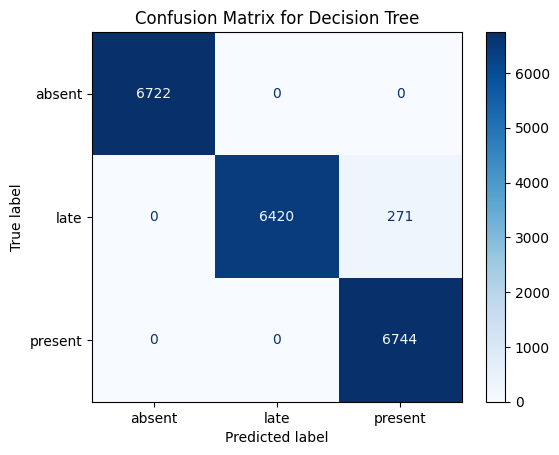

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix for Decision Tree
disp = ConfusionMatrixDisplay.from_estimator(dt_model, X_test, y_test, display_labels=label_encoder.classes_, cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.show()


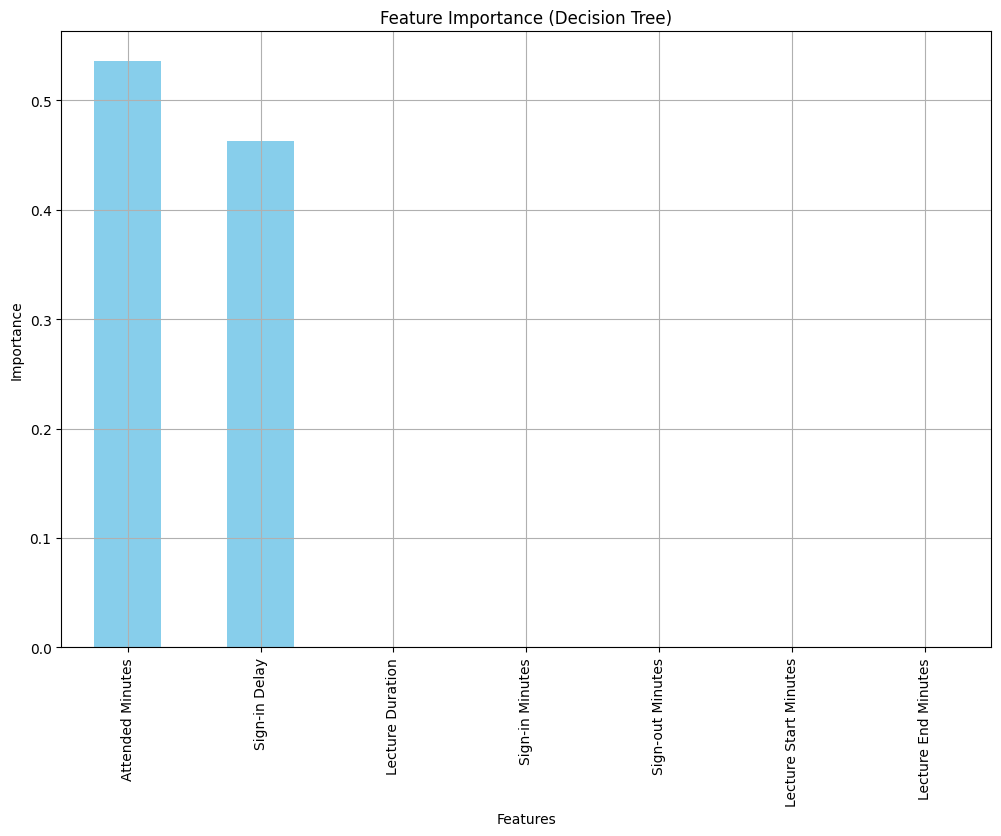

In [ ]:
# Feature importance visualization for Decision Tree
feature_importances = pd.Series(dt_model.feature_importances_, index=processed_data.drop(['Status Encoded'], axis=1).columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar', color='skyblue')
plt.title('Feature Importance (Decision Tree)')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.grid(True)
plt.show()


<ipython-input-25-9cd86ff52ff7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='coolwarm')


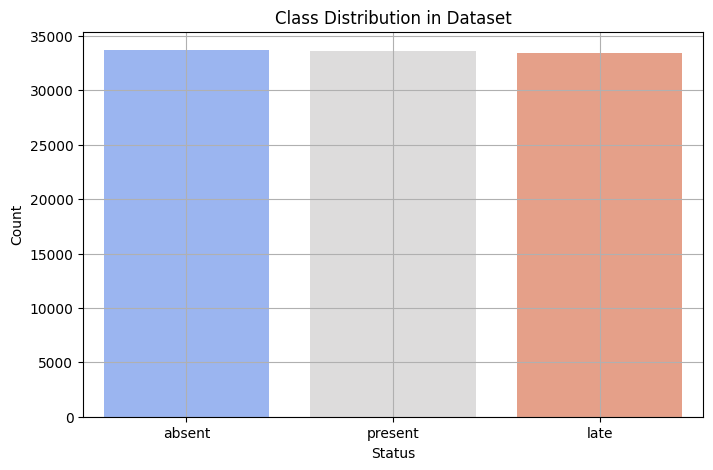

In [ ]:
import seaborn as sns

# Class distribution in the dataset
class_counts = attendance_data['Status'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='coolwarm')
plt.title('Class Distribution in Dataset')
plt.ylabel('Count')
plt.xlabel('Status')
plt.grid(True)
plt.show()


630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


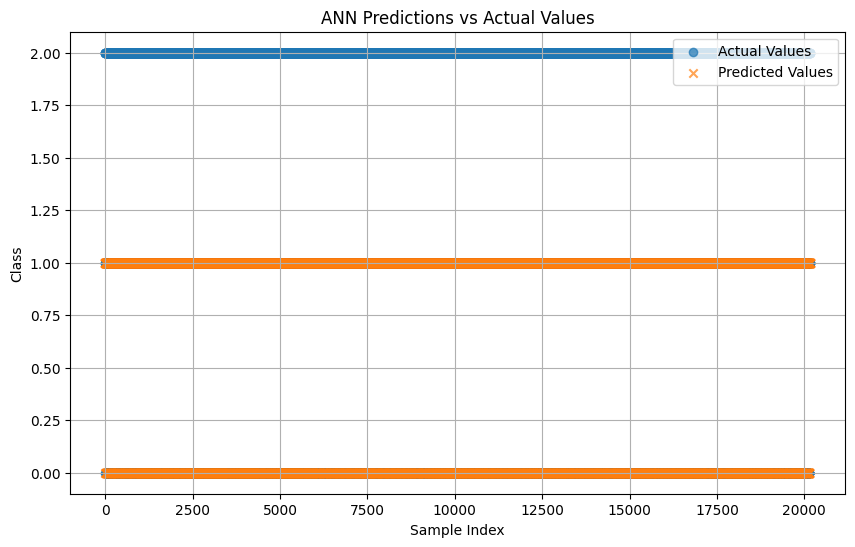

In [ ]:
import numpy as np

# Predict on the test set
y_pred_ann = (ann_model.predict(X_test) > 0.5).astype(int)

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual Values', marker='o', alpha=0.7)
plt.scatter(range(len(y_pred_ann)), y_pred_ann, label='Predicted Values', marker='x', alpha=0.7)
plt.title('ANN Predictions vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend()
plt.grid(True)
plt.show()
